<h1 align="center">信息隐藏与数字水印</h1>

<p style="text-align:center">唐麒 21120299</p>

### 实验一:基于 DCT/DFT 变换的图像水印算法

**目标**:将伪随机序列作为水印序列，嵌入到图像的 DCT 或 DFT 域系数中。通过相关检测判别水印是否存在。

**实验原理**:图像进行 DCT 或 DFT 变换(不分块)，选择 $K$ 个最大的系数(也可以尝试取值居中的 $K$ 个，随机 $K$ 个等方式)。产生包含 $K$ 个元素的伪随机数序列，比如符合正态分布。按照以下公式嵌入水印信息:

$$v_i'=v_i(1+\alpha x_i)$$

其中，$x_i$ 表示水印信息，$v_i$ 表示载体图像系数。

<img style="width:50%" src="./1.png"></img>

**代码实现**：

1. 基于 DCT 变换

In [1]:
import numpy as np
import cv2

In [2]:
def embed_watermark(image_path, k, a):
    # 加载图像
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 执行DCT或DFT变换
    transformed = cv2.dct(np.float32(image))  # 使用DCT变换，或者可以使用cv2.dft()函数进行DFT变换

    # 将变换系数展平
    flat_transformed = transformed.ravel()

    # 获取最大系数的索引
    max_indices = np.unravel_index(np.argsort(np.abs(flat_transformed)), transformed.shape)

    # 选择前k个最大的系数位置
    selected_indices = np.column_stack(max_indices)[-k:]

    # 产生伪随机数序列
    watermark_info = np.random.normal(size=k)

    # 嵌入水印信息
    embedded_transformed = transformed.copy()
    for index, value in zip(selected_indices, watermark_info):
        embedded_transformed[index[0]][index[1]] *= (1 + a * value)

    # 执行逆DCT或逆DFT变换
    embedded_image = cv2.idct(embedded_transformed)  # 使用逆DCT变换，或者可以使用cv2.idft()函数进行逆DFT变换

    return embedded_image, watermark_info, selected_indices

In [3]:
def detect_watermark(embedded_image, original_image, selected_indices, a):
    # 执行DCT或DFT变换
    embedded_transformed = cv2.dct(np.float32(embedded_image))  # 使用DCT变换，或者可以使用cv2.dft()函数进行DFT变换
    original_transformed = cv2.dct(np.float32(original_image))

    # 提取嵌入的水印信息
    extracted_watermark = []
    for _, index in enumerate(selected_indices):
        extracted_watermark.append(
            (embedded_transformed[index[0]][index[1]] - original_transformed[index[0]][index[1]]) / (a * original_transformed[index[0]][index[1]]))

    return extracted_watermark

In [4]:
def calculate_psnr(image1, image2):
    assert image1.shape == image2.shape, ('错误：两个输⼊图像的⼤⼩不⼀致: {image1.shape}, {image2.shape}.')
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        print('两幅图像完全⼀样')
        return 200
    psnr = 10 * np.log10((255 ** 2) / mse)
    return psnr

In [5]:
image_path = 'Lena_256.bmp'
k = 10  # 选择的DCT或DFT系数个数
a = 0.1  # 嵌入系数

# 嵌入水印
embedded_image, watermark_info, selected_indices = embed_watermark(image_path, k, a)

# 计算嵌入水印后图像的PSNR值
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
psnr = calculate_psnr(original_image, embedded_image)

# 提取水印
extracted_watermark = detect_watermark(embedded_image, original_image, selected_indices, a)

# 计算提取的水印与原始水印的相关值
correlation = np.corrcoef(watermark_info, extracted_watermark)[0, 1]

print("PSNR:", psnr)
print("Correlation:", correlation)

threshold = 0.5
if correlation > threshold:
    print("水印存在")
else:
    print("水印不存在")

PSNR: 38.82497554997011
Correlation: 0.9999999999994027
水印存在


2. 基于小波变换实现

In [6]:
import pywt
import numpy as np
import cv2

In [7]:
def embed_watermark(image, watermark, k, a):
    # 进行小波变换
    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs

    # 由于人眼对高频信息不敏感，将水印信息嵌入到高频小波系数中
    watermark_indices = np.unravel_index(np.argsort(np.abs(HH.ravel()), axis=None), HH.shape)
    selected_indices = np.column_stack(watermark_indices)[-k:]
    HH_watermarked = HH.copy()
    for indices, value in zip(selected_indices, watermark):
        HH_watermarked[indices[0]][indices[1]] *= (1 + a * value)

    # 逆小波变换恢复图像
    watermarked_coeffs = (LL, (LH, HL, HH_watermarked))
    watermarked_image = pywt.idwt2(watermarked_coeffs, 'haar')
    watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)

    return watermarked_image, selected_indices

In [8]:
def extract_watermark(image, original_image, selected_indices, a):
    # 进行小波变换
    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs

    original_coeffs = pywt.dwt2(original_image, 'haar')
    original_LL, (original_LH, original_HL, original_HH) = original_coeffs

    # 提取嵌入的水印信息
    extracted_watermark = []
    for indices in selected_indices:
        extracted_watermark.append((HH[indices[0]][indices[1]] - original_HH[indices[0]][indices[1]]) / (a * original_HH[indices[0]][indices[1]]))

    return extracted_watermark

In [9]:
# 加载图像
image = cv2.imread('./Lena_256.bmp', 0)

# 生成水印
k = 10
watermark = np.random.normal(size=k)
a = 0.1

# 嵌入水印
watermarked_image, selected_indices = embed_watermark(image, watermark, k, a)

# 提取水印
extracted_watermark = extract_watermark(watermarked_image, image, selected_indices, a)


def calculate_psnr(image1, image2):
    assert image1.shape == image2.shape, ('错误：两个输⼊图像的⼤⼩不⼀致: {image1.shape}, {image2.shape}.')
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        print('两幅图像完全⼀样')
        return 200
    psnr = 10 * np.log10((255 ** 2) / mse)
    return psnr


psnr = calculate_psnr(image, watermarked_image)
print("PSNR:", psnr)

# 判断水印是否存在
correlation = np.corrcoef(watermark, extracted_watermark)[0, 1]
print("Correlation:", correlation)

threshold = 0.5
if correlation > threshold:
    print("水印存在")
else:
    print("水印不存在")

PSNR: 66.49556919907863
Correlation: 0.9987793429660823
水印存在


<p style="font-color:red">可以看到，无论是基于 DCT 变换还是基于小波变换的实现，都可以较为准确地提取出嵌入的水印，但相较于 DCT 变换，小波变换造成的载体图像失真更小</p>

### 实验二：利⽤ DCT 域图像块系数关系的⽔印算法

**目标**:将二值图像作为水印，嵌入到灰度载体图像中。

**实验原理**:图像分为 $8\times8$ 的图像块，每个图像块嵌入 $1$ 比特水印。在每个图像块中， 选出 $2$ 个位置的系数，比较他们的大小。具体的，选出 $B(u_1, v_1)$和 $B(u_2, v_2)$两个系数，如果嵌入 $1$，使得 $B(u_1, v_1)>B(u_2, v_2)$;如果嵌入 0，使得 $B(u_1, v_1)<B(u_2, v_2)$。 最后，调整两个系数间的差距，保证鲁棒性。

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
class DCT_Embed(object):
    def __init__(self, background, watermark, block_size=8, alpha=30):
        b_h, b_w = background.shape[:2]
        w_h, w_w = watermark.shape[:2]
        assert w_h <= b_h / block_size and w_w <= b_w / block_size, \
            "\r\n请确保您的的水印图像尺寸 不大于 背景图像尺寸的1/{:}\r\nbackground尺寸{:}\r\nwatermark尺寸{:}".format(
                block_size, background.shape, watermark.shape
            )

        # 保存参数
        self.block_size = block_size
        # 水印强度控制
        self.alpha = alpha

    def dct_blkproc(self, background):
        """
        对background进行分块，然后进行dct变换，得到dct变换后的矩阵

        :param image: 输入图像
        :param split_w: 分割的每个patch的w
        :param split_h: 分割的每个patch的h
        :return: 经dct变换的分块矩阵、原始的分块矩阵
        """
        background_dct_blocks_h = background.shape[0] // self.block_size  # 高度
        background_dct_blocks_w = background.shape[1] // self.block_size  # 宽度
        background_dct_blocks = np.zeros(shape=(
            (background_dct_blocks_h, background_dct_blocks_w, self.block_size, self.block_size)
        ))  # 前2个维度用来遍历所有block，后2个维度用来存储每个block的DCT变换的值

        h_data = np.vsplit(background, background_dct_blocks_h)  # 垂直方向分成background_dct_blocks_h个块
        for h in range(background_dct_blocks_h):
            block_data = np.hsplit(h_data[h], background_dct_blocks_w)  # 水平方向分成background_dct_blocks_w个块
            for w in range(background_dct_blocks_w):
                a_block = block_data[w]
                background_dct_blocks[h, w, ...] = cv2.dct(a_block.astype(np.float64))  # dct变换
        return background_dct_blocks

    def dct_embed(self, dct_data, watermark):
        """
        将水印嵌入到载体的dct系数中
        :param dct_data: 背景图像（载体）的DCT系数
        :param watermark: 归一化二值图像0-1 (uint8类型)
        :return: 空域图像
        """
        temp = watermark.flatten()
        assert temp.max() == 1 and temp.min() == 0, "为方便处理，请保证输入的watermark是被二值归一化的"

        for h in range(watermark.shape[0]):
            for w in range(watermark.shape[1]):
                if watermark[h, w] == 0:
                    if dct_data[h, w, 4, 1] < dct_data[h, w, 3, 2]:
                        tmp = dct_data[h, w, 4, 1]
                        dct_data[h, w, 4, 1] = dct_data[h, w, 3, 2]
                        dct_data[h, w, 3, 2] = tmp
                else:
                    if dct_data[h, w, 4, 1] > dct_data[h, w, 3, 2]:
                        tmp = dct_data[h, w, 4, 1]
                        dct_data[h, w, 4, 1] = dct_data[h, w, 3, 2]
                        dct_data[h, w, 3, 2] = tmp
                if dct_data[h, w, 4, 1] < dct_data[h, w, 3, 2]:
                    dct_data[h, w, 4, 1] -= self.alpha
                else:
                    dct_data[h, w, 3, 2] -= self.alpha
        return dct_data

    def idct_embed(self, dct_data):
        """
        进行对dct矩阵进行idct变换，完成从频域到空域的变换
        :param dct_data: 频域数据
        :return: 空域数据
        """
        row = None
        result = None
        h, w = dct_data.shape[0], dct_data.shape[1]
        for i in range(h):
            for j in range(w):
                block = cv2.idct(dct_data[i, j, ...])
                row = block if j == 0 else np.hstack((row, block))
            result = row if i == 0 else np.vstack((result, row))
        return result.astype(np.uint8)

    def dct_extract(self, synthesis, watermark_size):
        """
        从嵌入水印的图像中提取水印
        :param synthesis: 嵌入水印的空域图像
        :param watermark_size: 水印大小
        :return: 提取的空域水印
        """
        w_h, w_w = watermark_size
        recover_watermark = np.zeros(shape=watermark_size)
        synthesis_dct_blocks = self.dct_blkproc(background=synthesis)
        for h in range(w_h):
            for w in range(w_w):

                if synthesis_dct_blocks[h, w, 4, 1] < synthesis_dct_blocks[h, w, 3, 2]:
                    recover_watermark[h, w] = 1
                else:
                    recover_watermark[h, w] = 0
        return recover_watermark

PSNR 28.804966484513063


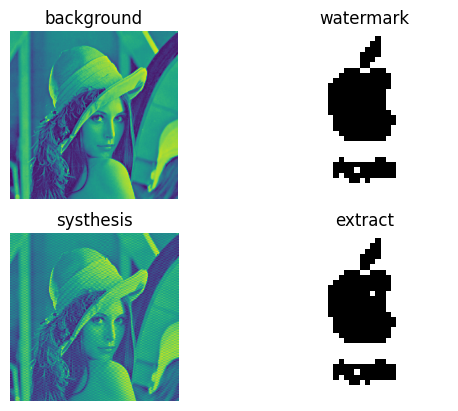

In [12]:
if __name__ == '__main__':
    root = ".."

    # 0. 超参数设置
    alpha = 100  # 尺度控制因子，控制水印添加强度，决定频域系数被修改的幅度
    blocksize = 8  # 分块大小

    # 1. 数据读取

    # watermak
    watermark = cv2.imread(r"./watermark_resize.png".format(root), cv2.IMREAD_GRAYSCALE)
    watermark = np.where(watermark < np.mean(watermark), 0, 1)  # watermark进行(归一化的)二值化
    background = cv2.imread(r"./Lena_256.bmp".format(root), cv2.IMREAD_GRAYSCALE)

    # 2. 初始化DCT算法
    dct_emb = DCT_Embed(background=background, watermark=watermark, block_size=blocksize, alpha=alpha)

    # 3. 进行分块与DCT变换
    background_dct_blocks = dct_emb.dct_blkproc(background=background)  # 得到分块的DCTblocks

    # 4. 嵌入水印图像
    embed_watermark_blocks = dct_emb.dct_embed(dct_data=background_dct_blocks, watermark=watermark)  # 在dct块中嵌入水印图像

    # 5. 将图像转换为空域形式
    synthesis = dct_emb.idct_embed(dct_data=embed_watermark_blocks)  # idct变换得到空域图像
    print("PSNR",calculate_psnr(background, synthesis))

    # 6. 提取水印
    extract_watermark = dct_emb.dct_extract(synthesis=synthesis, watermark_size=watermark.shape) * 255
    extract_watermark.astype(np.uint8)
    # 7. 可视化处理
    images = [background, watermark, synthesis, extract_watermark]
    titles = ["background", "watermark", "systhesis", "extract"]
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        if i % 2:
            plt.imshow(images[i], cmap=plt.cm.gray)
        else:
            plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

因为需要通过比较变换后的两个DCT系数来完成信息的隐藏，所以在传递秘密信息前，通信的双方就必须对要比较的两个位置达成一致。对于每一个$8\times8$图像块，共有64个系数，为了隐藏信息的不可见性，要求在其中选择两个恰当的系数$a$，$b$，使得这两个位置上的数据在图像经过处理后差别不大。因此，选择DCT系数中的中频系数，可以兼顾信息隐藏的不可见性与鲁棒性。如果选择低频系数，由于其所相应的能量过大，秘密消息的不可见性差，如果选择高频系数，则能量最低，很容易被篡改，鲁棒性差。中频系数的频率适中，既不会太容易被篡改，保证了鲁棒性，也不会能量太高，破坏不可见性。综上，选择$(5,2)$和$(4,3)$这一对系数。但由于这样的一对系数大小相差很少，往往难以保证隐秘图像在保存、信道上传输以及提取信息时再次被读取等过程中不发生变化。所以，再引入一个控制量$\alpha$对系数差值进行放大。这样即使在变换过程中系数的值有轻微的改变，也不会影响编码的正确性。当α=0时，即不设置α时，可以发现信息提取有误。

PSNR 42.222951891600744


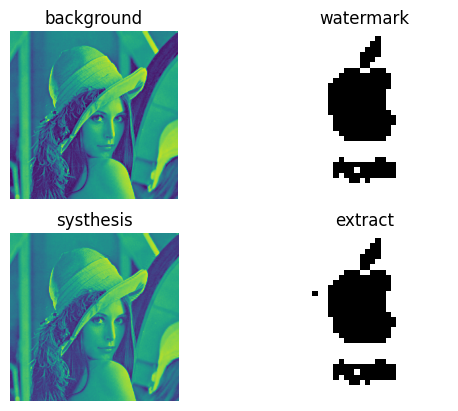

In [13]:
if __name__ == '__main__':
    root = ".."

    # 0. 超参数设置
    alpha = 0  # 尺度控制因子，控制水印添加强度，决定频域系数被修改的幅度
    blocksize = 8  # 分块大小

    # 1. 数据读取

    # watermak
    watermark = cv2.imread(r"./watermark_resize.png".format(root), cv2.IMREAD_GRAYSCALE)
    watermark = np.where(watermark < np.mean(watermark), 0, 1)  # watermark进行(归一化的)二值化
    background = cv2.imread(r"./Lena_256.bmp".format(root), cv2.IMREAD_GRAYSCALE)

    # 2. 初始化DCT算法
    dct_emb = DCT_Embed(background=background, watermark=watermark, block_size=blocksize, alpha=alpha)

    # 3. 进行分块与DCT变换
    background_dct_blocks = dct_emb.dct_blkproc(background=background)  # 得到分块的DCTblocks

    # 4. 嵌入水印图像
    embed_watermark_blocks = dct_emb.dct_embed(dct_data=background_dct_blocks, watermark=watermark)  # 在dct块中嵌入水印图像

    # 5. 将图像转换为空域形式
    synthesis = dct_emb.idct_embed(dct_data=embed_watermark_blocks)  # idct变换得到空域图像
    print("PSNR",calculate_psnr(background, synthesis))

    # 6. 提取水印
    extract_watermark = dct_emb.dct_extract(synthesis=synthesis, watermark_size=watermark.shape) * 255
    extract_watermark.astype(np.uint8)
    # 7. 可视化处理
    images = [background, watermark, synthesis, extract_watermark]
    titles = ["background", "watermark", "systhesis", "extract"]
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        if i % 2:
            plt.imshow(images[i], cmap=plt.cm.gray)
        else:
            plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis("off")
    plt.show()